In [1]:
%pip install cvxpy seaborn


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import cvxpy as cp
import seaborn as sns
import pandas as pd
from scipy import stats

sns.set_theme()

In [3]:
def read_input(file_path):
    # by default a row of numbers in loaded as a 1D vector
    data = np.loadtxt(file_path)
    return data

In [4]:
poly_path = "PA-1-data-text/polydata_data_"
X_sample = read_input(f"{poly_path}sampx.txt")
y_sample = read_input(f"{poly_path}sampy.txt")
X_poly = read_input(f"{poly_path}polyx.txt")
y_poly = read_input(f"{poly_path}polyy.txt")

## Part 1: Polynomial function

For this part, we first define a base class for all regression models.

In [5]:
class Regression:
    """Abstract base class for all regression models.

    Suppose a scalar function f(x, θ) with an input x ∈ R^d and an unknown parameter
    θ ∈ R^D has the form
    
        f(x, θ) = ϕ(x)^T θ,
    
    where ϕ: R^d → R^D is a known feature transformation. Given a dataset of n pairs
    (x_i, y_i) of input and *noisy* output, our goal is to estimate the value of the
    parameter θ and use it to predict the output of the function with a new input x*.
    For convenience, we define three variables

        y = [y_1 ... y_n]^T,    Φ = [ϕ(x_1) ... ϕ(x_n)],    X = [x_1 ... x_n].

    The API here mirrors that of a model in scikit-learn with two main methods:
    - `fit(X, y)`: estimate the parameter using the given data (training)
    - `predict(x)`: predict the output corresponds to the given input (inference)
    """

    def __init__(self, phi):
        """Create a model with the feature transformation phi: R^d → R^D."""
        self.phi = phi

    def fit(self, X, y):
        pass

    def predict(self, x):
        pass

### (a) Implement 5 regression algorithms

In [6]:
class LS(Regression):
    """Least Squares (LS) Regression

    This regression model aims to minimize the L2-norm of the difference between the
    given output and the output of the function, i.e.

       θ^_LS = argmin_θ ‖y - Φ^T θ‖^2
             = (ΦΦ^T)^(-1)Φy

    The prediction for input x* is then f* = ϕ(x*)^T θ^.
    """

    def fit(self, X, y):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        inv = np.linalg.inv(Phi @ Phi.T)
        self.theta_hat = inv @ Phi @ y
        return self.theta_hat

    def predict(self, X):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        return Phi.T @ self.theta_hat

In [7]:
class RLS(Regression):
    """Regularized Least Squares (RLS) Regression

    This regression model aims to minimize the L2-norm of the difference between the
    real and the predicted outputs, together with the L2-norm of the parameter as a
    penalty term, i.e.,

       θ^_LS = argmin_θ ‖y - Φ^T θ‖^2 + λ‖θ‖^2
             = (ΦΦ^T + λI)^(-1)Φy

    Here, λ is a hyperparameter. The prediction for input x* is then f* = ϕ(x*)^T θ^.
    """
    def __init__(self, phi, l):
        self.phi = phi
        self.l = l

    def fit(self, X, y):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        D = Phi.shape[0]
        inv = np.linalg.inv(Phi @ Phi.T + self.l * np.identity(D))
        self.theta_hat = inv @ Phi @ y
        return self.theta_hat

    def predict(self, X):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        return Phi.T @ self.theta_hat

In [8]:
class LASSO(Regression):
    """LASSO Regression

    This regression model aims to minimize the L2-norm of the difference between the
    real and the predicted outputs, together with the L1-norm of the parameter as a
    penalty term, i.e.,

        θ^_LASSO = argmin_θ ‖y - Φ^T θ‖^2 + λ‖θ‖_1

    Here, λ is a hyperparameter. The prediction for input x* is then f* = ϕ(x*)^T θ^.
    This optimization problem does not have a closed form solution and requires
    quadratic programming to estimate its solution.
    """

    def __init__(self, phi, l):
        self.phi = phi
        self.l = l

    def fit(self, X, y):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        D = Phi.shape[0]
        Phi_Phi_T = Phi @ Phi.T
        Phi_y = Phi @ y

        H = np.block([[Phi_Phi_T, -Phi_Phi_T], [-Phi_Phi_T, Phi_Phi_T]])
        f = self.l - np.block([Phi_y, -Phi_y])
        x = cp.Variable(2*D)

        objective = cp.Minimize(x.T @ H @ x / 2 + f.T @ x)
        constraints = [x >= 0]
        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.CLARABEL)

        self.theta_hat = x.value[:D] - x.value[D:]
        return self.theta_hat

    def predict(self, X):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        return Phi.T @ self.theta_hat

In [9]:
class RR(Regression):
    """Robust Regression

    This regression model aims to minimize the L1-norm of the difference between the
    real and the predicted outputs, i.e.,

        θ^_RR = argmin_θ ‖y - Φ^T θ‖_1

    The prediction for input x* is then f* = ϕ(x*)^T θ^. This optimization problem does
    not have a closed form solution and requires linear programming to estimate its
    solution.
    """

    def fit(self, X, y):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        D, n = Phi.shape

        A = np.block([[-Phi.T, -np.identity(n)], [Phi.T, -np.identity(n)]])
        f = np.block([np.zeros(D), np.ones(n)])
        b = np.block([-y, y])
        x = cp.Variable(D+n)

        objective = cp.Minimize(f @ x)
        constraints = [A @ x <= b]
        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.CLARABEL)

        self.theta_hat = x.value[:D]
        return self.theta_hat

    def predict(self, X):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        return Phi.T @ self.theta_hat

In [10]:
class BR(Regression):
    """Bayesian Regression

    This regression model aims to update its prior beliefs about the parameter using
    the given data to produce the posterior distribution of the parameter. Suppose θ
    has multivariate i.i.d. Gaussian prior distribution θ ~ N(0, αI) and the observed
    outputs have Gaussian noises with constant variance added to the "true" output,
    i.e., the sampling distribution is y|x,θ ~ N(f(x,θ), σ^2). Then, the posterior is

        θ|X,y ~ N(μ^_θ, Σ^_θ^2)
        μ^_θ = σ^(-2) Σ^_θ Φy
        Σ^_θ = (α^(-1)I + σ^(-2)ΦΦ^T)^(-1)

    The predictive distribution for input x* is a Gaussian, with

        f*|X,y,x* ~ N(μ^*, σ^*^2)
        μ^* = ϕ(x*)^T μ^_θ
        σ^*^2 = ϕ(x*)^T Σ^_θ ϕ(x*)
    """
    def __init__(self, phi, alpha, sigma_2):
        self.phi = phi
        self.alpha = alpha
        self.sigma_2 = sigma_2

    def fit(self, X, y):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        Phi_Phi_T = Phi @ Phi.T
        D = Phi.shape[0]

        self.Sigma_hat_theta = np.linalg.inv(np.identity(D) / self.alpha + Phi_Phi_T / self.sigma_2)
        self.mu_hat_theta = self.Sigma_hat_theta @ Phi @ y / self.sigma_2
        return (self.mu_hat_theta, self.Sigma_hat_theta)

    def predict(self, X):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        mu_hat = Phi.T @ self.mu_hat_theta
        # assuming the novel inputs are independent
        sigma_2_hat = np.diag(np.diag((Phi.T @ self.Sigma_hat_theta @ Phi)))
        rng = np.random.default_rng(seed=30)
        return stats.multivariate_normal.rvs(mean=mu_hat, cov=sigma_2_hat, random_state=rng)

### (b) Fit, predict, and plot

In [13]:
def fit_predict_plot(Model, *args, title=None):
    poly_5 = lambda x: x[0]**np.array(range(6))
    model = Model(poly_5, *args)
    result = model.fit(X_sample, y_sample)
    y_poly_predict = model.predict(X_poly)
    mse = np.square(y_poly - y_poly_predict).mean()

    df_sample = pd.DataFrame({
        'x': X_sample,
        'y': y_sample,
        'type': ['sample' for _ in range(X_sample.size)],
    })
    df_poly = pd.DataFrame({
        'x': X_poly,
        'y': y_poly,
        'type': ['poly' for _ in range(X_poly.size)],
    })
    df_poly_predict = pd.DataFrame({
        'x': X_poly,
        'y': y_poly_predict,
        'type': ['poly_predict' for _ in range(X_poly.size)],
    })
    df = pd.concat([df_sample, df_poly, df_poly_predict], axis=0)

    print(f"Estimated parameter:\n{result}")
    print(f"MSE: {mse}")
    sns.scatterplot(df, x='x', y='y', hue='type').set_title(title)

Estimated parameter:
[ 6.15769274e-01  1.10406633e+00  1.33022515e+00 -6.93228415e-01
  9.17835000e-04 -6.86117508e-01]
MSE: 0.4086438835698797


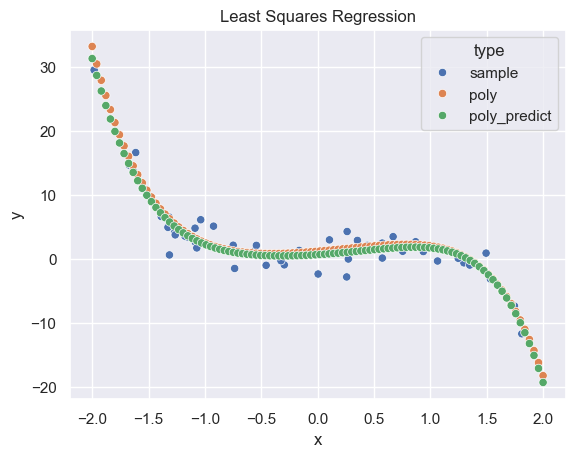

In [14]:
fit_predict_plot(LS, title="Least Squares Regression")

Estimated parameter:
[ 0.65265713  0.92763439  1.24731556 -0.53852581  0.02432706 -0.71581438]
MSE: 0.4075989710102732


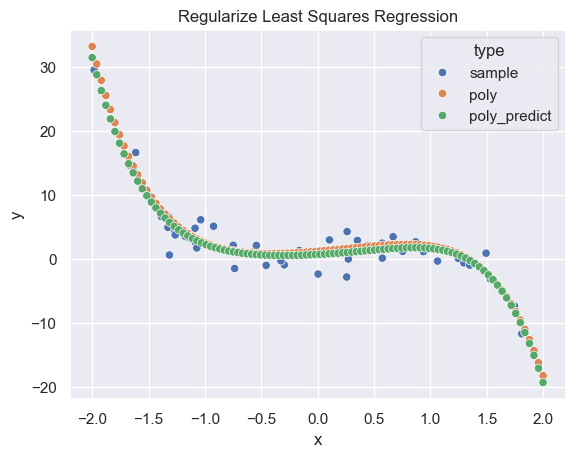

In [15]:
fit_predict_plot(RLS, 0.48, title="Regularize Least Squares Regression")

Estimated parameter:
[ 6.15781168e-01  1.10404256e+00  1.33020263e+00 -6.93208313e-01
  9.24229394e-04 -6.86121271e-01]
MSE: 0.40863932006485465


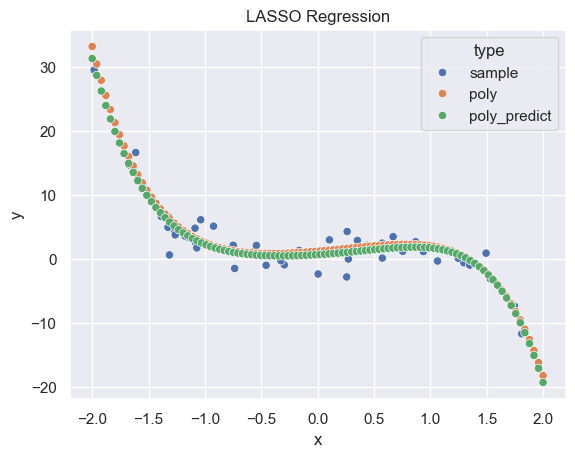

In [16]:
fit_predict_plot(LASSO, 0, title="LASSO Regression")

Estimated parameter:
[ 1.01563729  1.86713474  0.26492253 -1.70405013  0.34503288 -0.40769655]
MSE: 0.7680463117516123


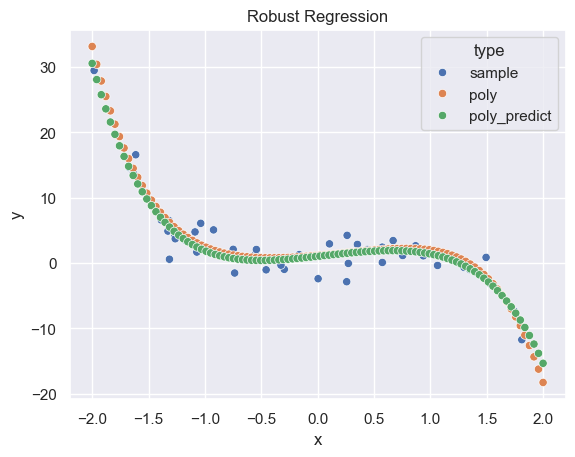

In [17]:
fit_predict_plot(RR, title="Robust Regression")

Estimated parameter:
(array([ 0.63012063,  1.03177997,  1.2996089 , -0.62866253,  0.0093718 ,
       -0.69872149]), array([[ 0.01261639, -0.00122106, -0.01564442, -0.00041736,  0.00385751,
         0.0003706 ],
       [-0.00122106,  0.04669982, -0.00212378, -0.04412914,  0.00141536,
         0.00916638],
       [-0.01564442, -0.00212378,  0.03501071,  0.00858872, -0.01062833,
        -0.00289452],
       [-0.00041736, -0.04412914,  0.00858872,  0.05052885, -0.00368499,
        -0.01168763],
       [ 0.00385751,  0.00141536, -0.01062833, -0.00368499,  0.0035939 ,
         0.00118306],
       [ 0.0003706 ,  0.00916638, -0.00289452, -0.01168763,  0.00118306,
         0.00291122]]))
MSE: 0.3657160050013992


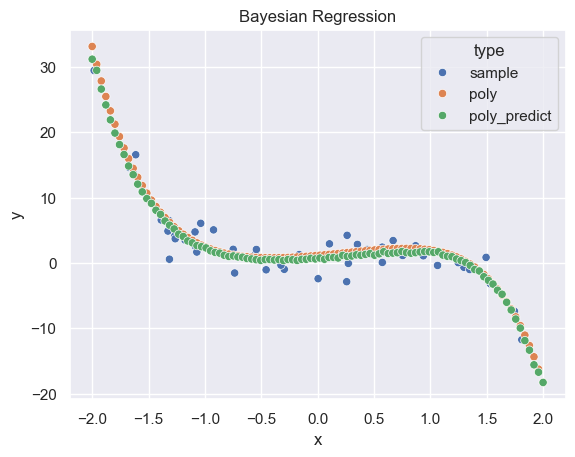

In [18]:
fit_predict_plot(BR, 1, 0.17, title="Bayesian Regression")